In [2]:
import pandas as pd
from datetime import timedelta

In [3]:
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)

# Collect Files

## Asset Lists

In [4]:
asset_lists = v4.coverage_equ([-1])
asset_lists = asset_lists[['PermID', 'Name', 'RIC']]

## Price Data

In [5]:
ftse_price_df = pd.read_csv('files/1.1-FTSE_PRICES_2006-2023.csv')
ftse_price_df = ftse_price_df.iloc[:, 1:]
ftse_price_df['Month'] = ftse_price_df['Date'].astype(str).apply(lambda x: x[:8] + '01')

## Merge Aggregate with Asset Lists

In [6]:
asset_lists.PermID = asset_lists.PermID.astype(int)
ftse_price_df = pd.merge(ftse_price_df, asset_lists, how = 'left', left_on = 'Asset', right_on = 'PermID').drop(['PermID'], axis=1)
# ftse_price_df.index = pd.to_datetime(ftse_price_df.Date)

## Aggregate File

In [7]:
ftse_master_df = pd.DataFrame()
blank_days = 30
for asset in ftse_price_df.Asset.unique():

    temp_df = ftse_price_df[ftse_price_df.Asset == asset].copy()
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    # temp_df.index = temp_df['Date']

    temp_df['Jump'] = temp_df['Date'].diff() > timedelta(days=blank_days)
    temp_df['Group'] = temp_df['Jump'].cumsum()
    temp_df['pct_change'] = temp_df.groupby('Group')['Close'].pct_change()
    temp_df.drop(['Group','Jump'], axis=1, inplace=True)

    ftse_master_df = pd.concat([ftse_master_df,temp_df])

In [8]:
ftse_master_df['|pct_change|'] = ftse_master_df['pct_change'].abs()
agg_max_changes = ftse_master_df.groupby(['Asset','Name'], as_index=False)[['|pct_change|']].max()
agg_max_changes = agg_max_changes.sort_values('|pct_change|', ascending=False)
temp_df = ftse_master_df[['Asset','|pct_change|', 'Date']]

agg_max_changes = pd.merge(agg_max_changes, temp_df, how='left', on = ['Asset','|pct_change|'])
del temp_df

In [9]:
ftse_master_df.head()

,Asset,Date,Open,High,Low,Close,Volume,UnadjClose,Currency,Month,Name,RIC,pct_change,|pct_change|
0,4295856631,2006-01-03,9.384185,9.486490,9.365584,9.486490,2.503309e+06,10.20,AUD,2006-01-01,Brambles Ltd,BXB.AX,NaN,NaN
1,4295856631,2006-01-04,9.505091,9.663199,9.505091,9.616697,2.410045e+06,10.34,AUD,2006-01-01,Brambles Ltd,BXB.AX,0.013725,0.013725
2,4295856631,2006-01-05,9.700401,9.746904,9.625997,9.663199,4.212039e+06,10.39,AUD,2006-01-01,Brambles Ltd,BXB.AX,0.004836,0.004836
3,4295856631,2006-01-06,9.598096,9.616697,9.505091,9.560894,3.953997e+06,10.28,AUD,2006-01-01,Brambles Ltd,BXB.AX,-0.010587,0.010587
4,4295856631,2006-01-09,9.598096,9.653899,9.598096,9.625997,3.145075e+06,10.35,AUD,2006-01-01,Brambles Ltd,BXB.AX,0.006809,0.006809


In [10]:
ftse_master_pivot_df = pd.pivot_table(data=ftse_master_df, columns='Asset', values='Close', index='Date')
ftse_master_chnge_pivot_df = pd.pivot_table(data=ftse_master_df, columns='Asset', values='|pct_change|', index='Date')

In [11]:
agg_max_changes.head(2)

,Asset,Name,|pct_change|,Date
0,8589934333,Barclays PLC,0.732422,2009-01-26
1,4295896428,Autonomy Corp Ltd,0.715885,2011-08-19


In [12]:
unique_assets = agg_max_changes.loc[:25, 'Asset'].tolist()

In [13]:
def func_vis_daily_data(df, df_agg, unique_assets):
    
    ranges = list(range(0, len(unique_assets) + 1, 25))
    # ranges.append(210)
    print(ranges)

    for i in range(1, len(ranges)):
        start = ranges[i-1]  # previous index
        end = ranges[i]  # current index
        length_ax = 15
        
        number_of_assets = len(unique_assets[start:end])
        if number_of_assets < 25:
            length_ax = 7
        
        fig, axs = plt.subplots(int(number_of_assets/5), 5, figsize=(15, length_ax))
        print('total unique assets:', number_of_assets)

        for idx, asset in enumerate(unique_assets[start:end]):
            
            temp_df = df[[asset]].copy()
            
            mx_ch = np.round(df_agg[df_agg['Asset'] == asset].iloc[0,-2], 2)
            firm = df_agg[df_agg['Asset'] == asset].iloc[0, 1]
            dates = df_agg[df_agg['Asset'] == asset].iloc[0, -1]
            start_date = dates - timedelta(days=30)
            end_date = dates + timedelta(days=30)

            i = idx // 5
            j = idx % 5

            temp_df = temp_df[(temp_df.index >= start_date) & (temp_df.index <= end_date)]
        
            axs[i, j].plot(temp_df[asset])
            axs[i, j].axvline(dates, color = 'r', linestyle='--')
            axs[i, j].set_title(f'{firm}-{asset}-{mx_ch}', fontsize = 7)
            
            for label in axs[i, j].get_xticklabels():
                label.set_rotation(25)  # Rotate labels by 45 degrees

        plt.tight_layout(pad=1.0)
        plt.show()
        # break

In [14]:
agg_max_changes.head(25)

,Asset,Name,|pct_change|,Date
0,8589934333,Barclays PLC,0.732422,2009-01-26
1,4295896428,Autonomy Corp Ltd,0.715885,2011-08-19
2,8589934212,Natwest Group PLC,0.665706,2009-01-19
3,4295896565,Vanquis Banking Group PLC,0.662178,2017-08-22
4,5036206981,Polymetal International PLC,0.560120,2022-02-28
5,8589934254,Lloyds Banking Group PLC,0.503726,2009-01-28
6,4295895061,Sibanye Uk Ltd,0.477362,2008-08-06
7,4295897861,Micro Focus International Ltd,0.463518,2018-03-19
8,4295895232,RSA Insurance Group Ltd,0.457472,2020-11-05
9,5033562382,Rolls-Royce Holdings PLC,0.437608,2020-11-09


In [20]:
pd.DataFrame(ftse_master_pivot_df[4295896565]).to_excel('files/inspection.xlsx')

[0, 25]
total unique assets: 25


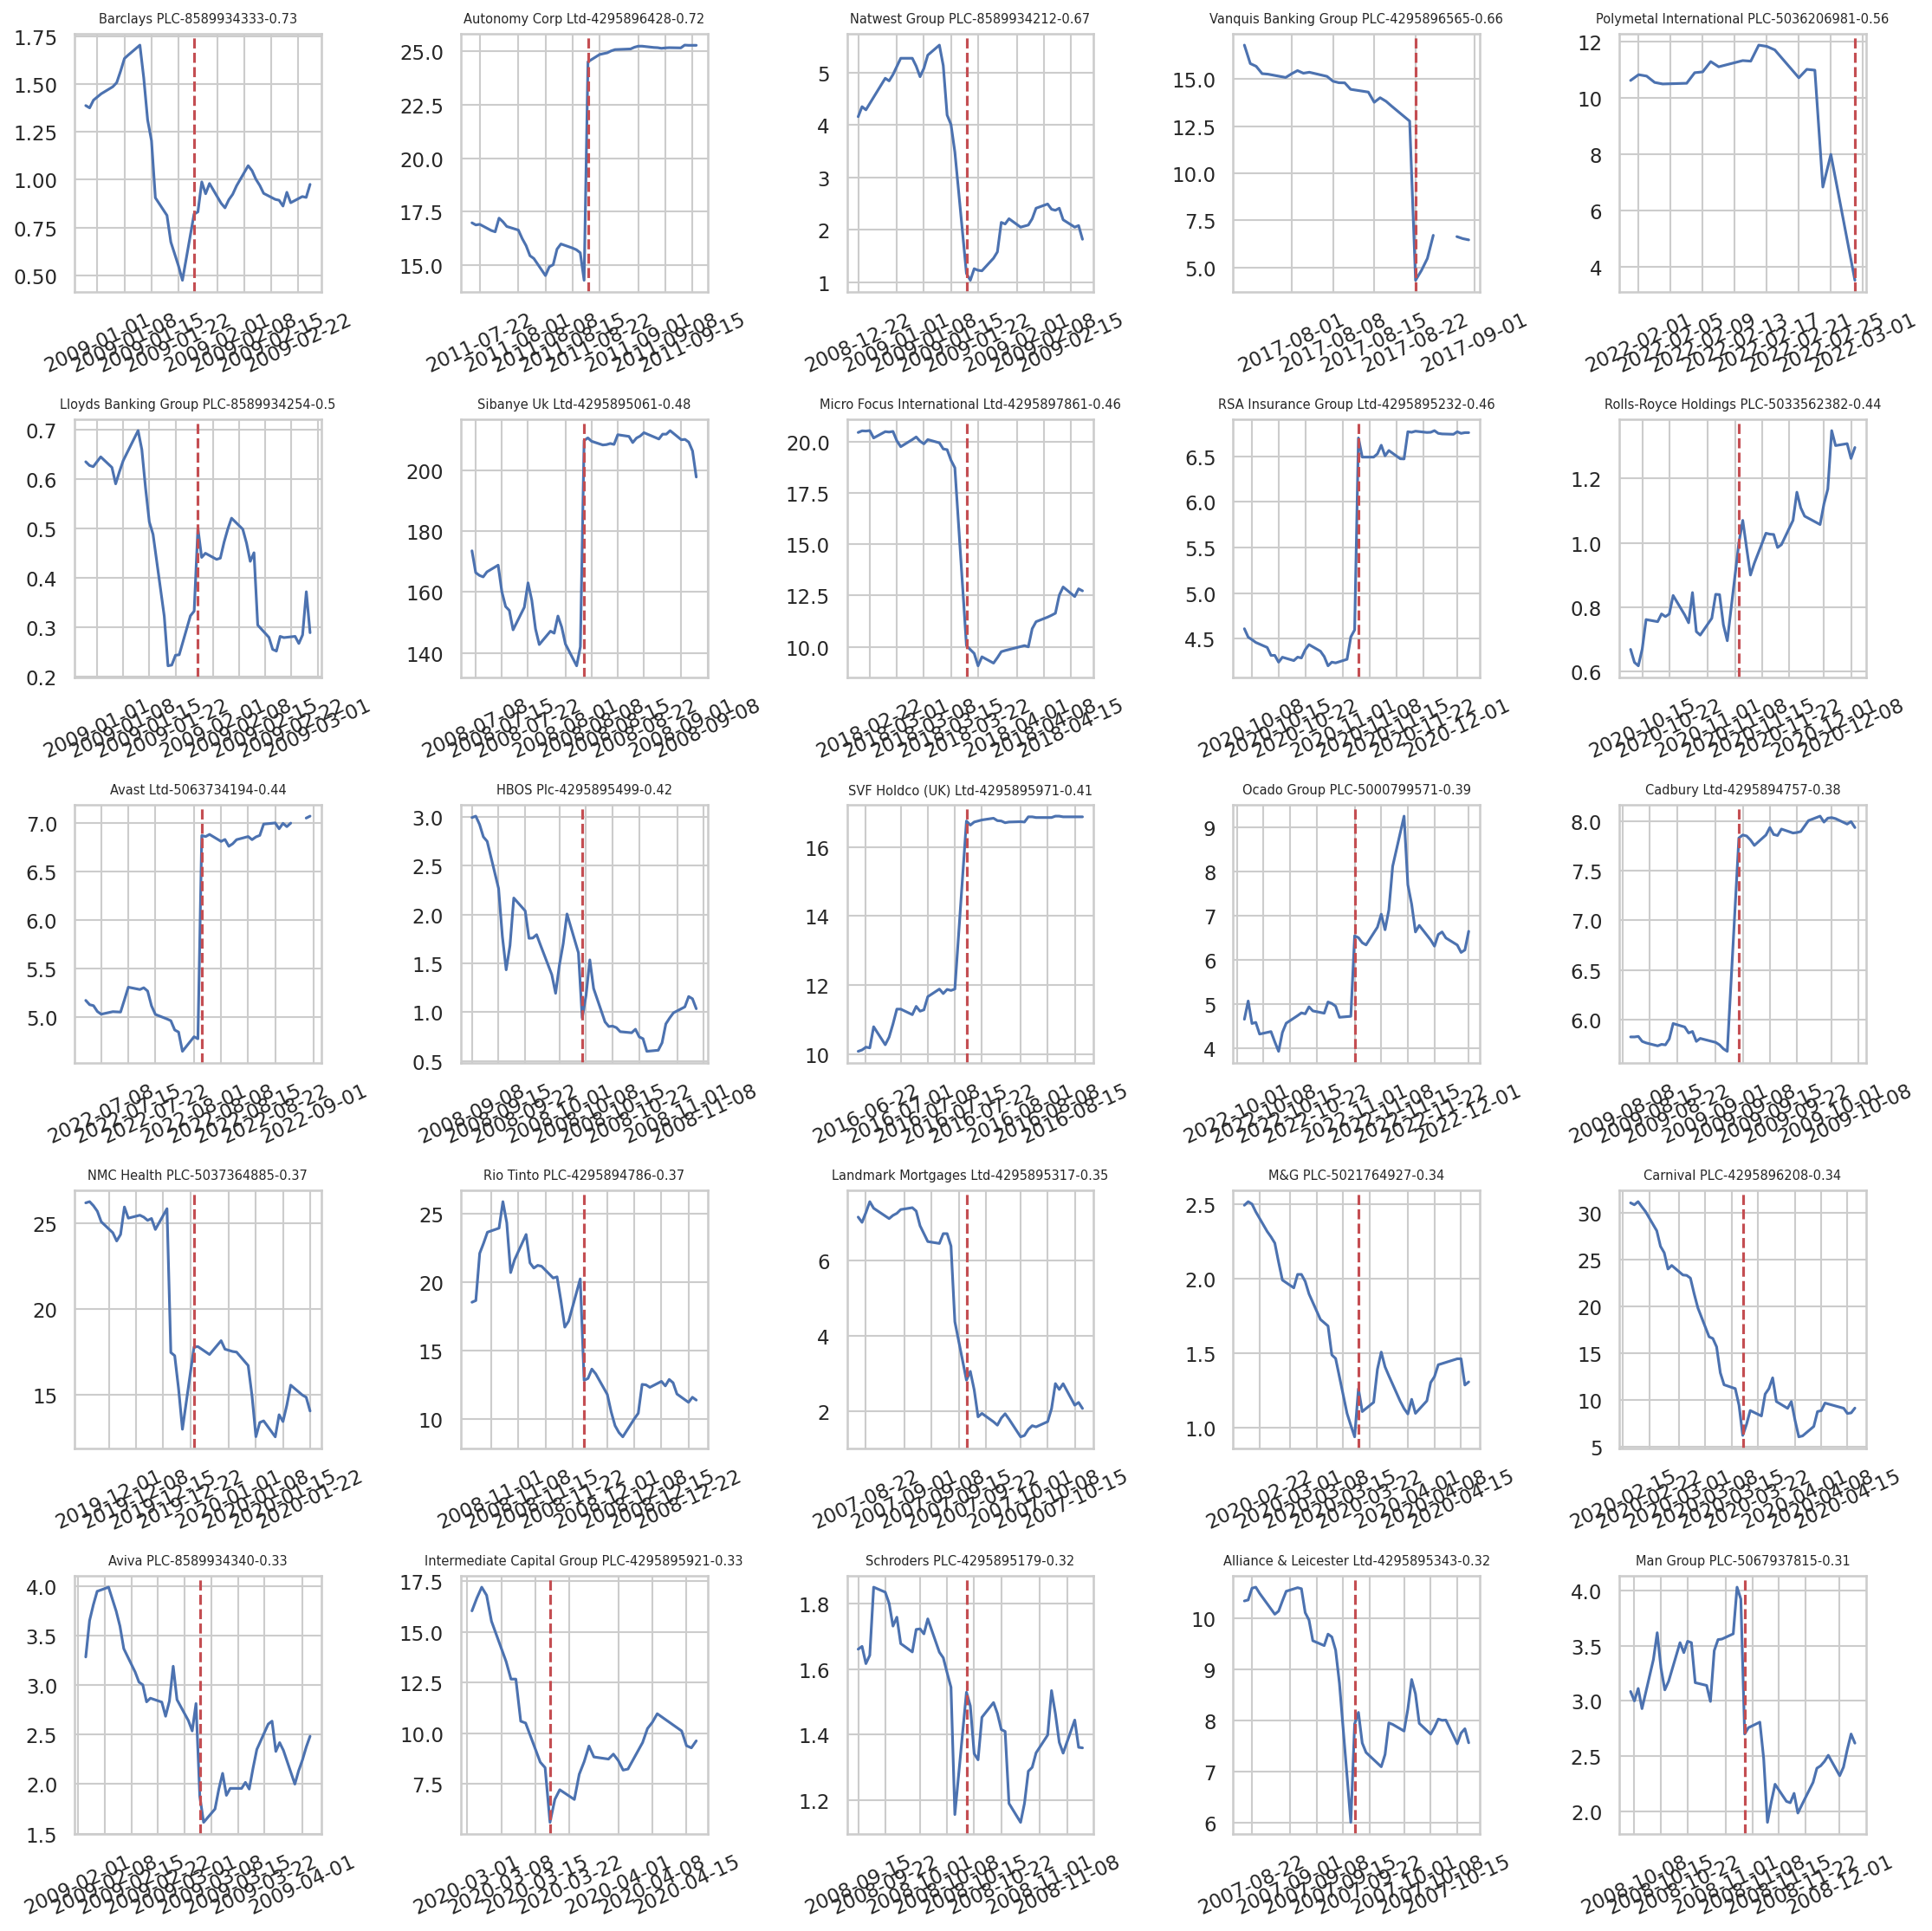

In [14]:
func_vis_daily_data(ftse_master_pivot_df, agg_max_changes, unique_assets=unique_assets)

In [15]:
agg_max_changes.to_csv('files/price_max_changes_2006-2023.csv', index=None)

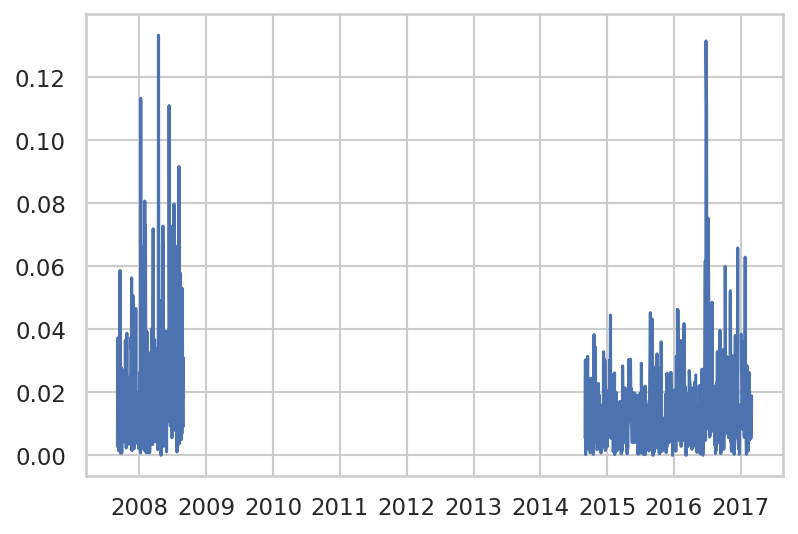

In [16]:
plt.plot(ftse_master_chnge_pivot_df[5000683618])